##Task 3

In [ ]:
# Colab-ready script: Task 3 — Dirichlet label skew + FedAvg experiments
# Paste into a Colab cell and run.
# Author: ChatGPT (assistive code). Adjust hyperparameters below as needed.

# 0) Install / ensure packages
!pip -q install torch torchvision --upgrade

# 1) Imports & basic settings
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
import torchvision, torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import numpy as np, random, copy, math, time, os
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import trange

In [ ]:


# 2) Experiment hyperparameters (change these if you want)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 12345
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False

# Data / clients
M = 5                      # number of clients
total_samples = 5000       # total samples to use from CIFAR-10 train set (must be divisible by M for IID but Dirichlet doesn't require equal)
per_client_min = 10        # sanity min per-client samples (not enforced, just warning)

# FedAvg hyperparams (fixed across alpha runs)
K = 5                      # local epochs per round
ROUNDS = 30                # communication rounds (use 30 for quick checks; increase if you can)
LOCAL_BS = 64
LR = 0.01
MOMENTUM = 0.9

# Dirichlet alphas to sweep
ALPHAS = [0.05, 0.2, 1.0, 100.0]

# Repeats for each alpha (set to >1 for mean/std curves; default 1 to save compute)
REPEATS = 1

In [ ]:

# 3) Dataset and transforms
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.261))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.261))
])

print("Device:", DEVICE)

Device: cuda


In [ ]:

# Download CIFAR-10 (will use subset)
full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create subset indices (shuffled)
all_indices = list(range(len(full_train)))
random.shuffle(all_indices)
subset_indices = all_indices[:total_samples]
subset_labels = [full_train[i][1] for i in subset_indices]

In [ ]:
# Helper: model (small CNN)
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)  # 16x16
        self.fc1 = nn.Linear(64*16*16, 256)
        self.fc2 = nn.Linear(256, num_classes)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Utility helpers for parameters and evaluation
def get_param_tensors(model):
    return [p.data.clone().cpu() for p in model.parameters()]

def set_param_tensors(model, tensors):
    for p, t in zip(model.parameters(), tensors):
        p.data.copy_(t.to(p.device))

def param_l2_norm_diff(paramsA, paramsB):
    s = 0.0
    for a,b in zip(paramsA, paramsB):
        diff = (a - b).view(-1)
        s += float((diff*diff).sum().cpu())
    return math.sqrt(s)

def evaluate(model, loader, device):
    model.eval()
    total = 0
    correct = 0
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            running_loss += float(criterion(out, yb).item())
            preds = out.argmax(dim=1)
            correct += int((preds == yb).sum().item())
            total += yb.size(0)
    return running_loss / total, correct / total


Starting alpha = 0.05
  client sizes: [897, 726, 196, 1874, 1307]
  Run 1/1 for alpha=0.05: Running FedAvg (rounds=30, K=5)
Round 1/30 | avg_drift=2.0557e+00 | test_acc=0.2256
Round 4/30 | avg_drift=2.7912e+00 | test_acc=0.3221
Round 7/30 | avg_drift=2.4099e+00 | test_acc=0.4165
Round 10/30 | avg_drift=1.6324e+00 | test_acc=0.3582
Round 13/30 | avg_drift=1.9590e+00 | test_acc=0.3752
Round 16/30 | avg_drift=1.6887e+00 | test_acc=0.3934
Round 19/30 | avg_drift=1.4493e+00 | test_acc=0.4399
Round 22/30 | avg_drift=1.4320e+00 | test_acc=0.4315
Round 25/30 | avg_drift=1.3753e+00 | test_acc=0.4299
Round 28/30 | avg_drift=1.7047e+00 | test_acc=0.4152
Round 30/30 | avg_drift=1.2564e+00 | test_acc=0.4350

Starting alpha = 0.2
  client sizes: [1060, 317, 1965, 472, 1186]
  Run 1/1 for alpha=0.2: Running FedAvg (rounds=30, K=5)
Round 1/30 | avg_drift=2.0007e+00 | test_acc=0.2337
Round 4/30 | avg_drift=2.2374e+00 | test_acc=0.4567
Round 7/30 | avg_drift=1.9870e+00 | test_acc=0.4152
Round 10/30 | a

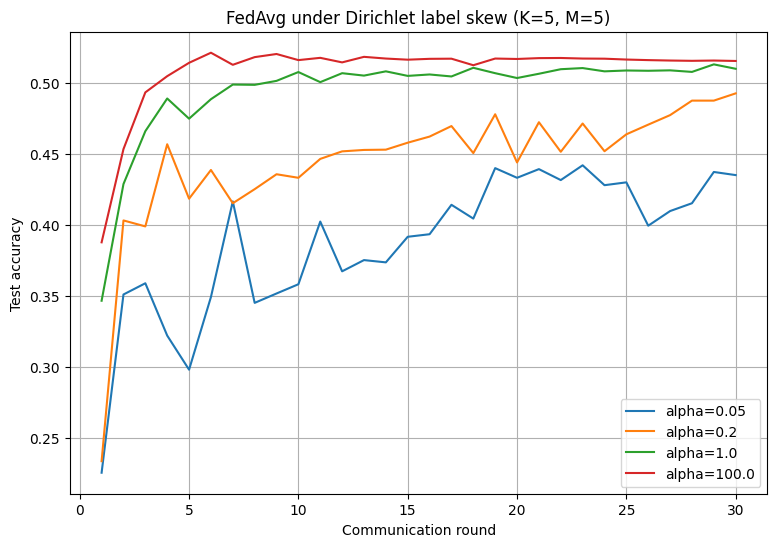

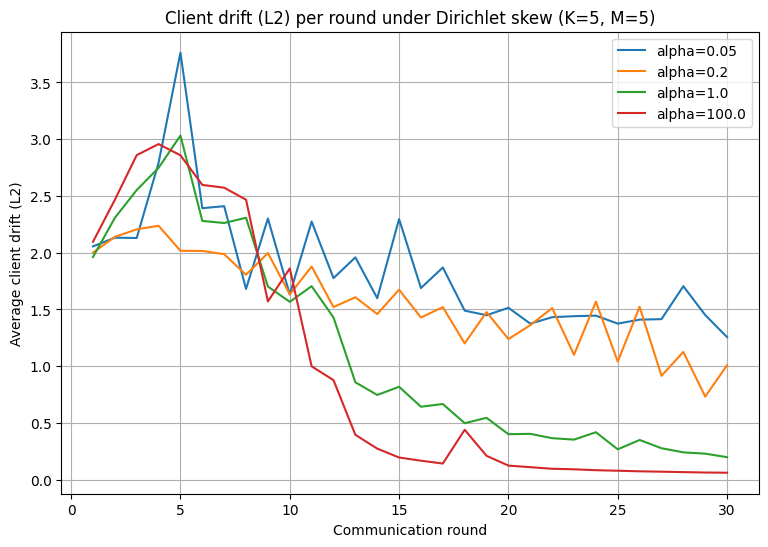


Final results summary (after 30 rounds):
alpha	final_acc	mean_drift_last5
0.05	0.4350	1.4474e+00
0.2	0.4925	1.0612e+00
1.0	0.5098	2.5937e-01
100.0	0.5153	6.7370e-02

Saved plots to ./task3_results/. Done.


In [ ]:
# 4) Dirichlet partition function (robust: uses multinomial per class)
def dirichlet_partition(labels, M, alpha, seed=None):
    """
    labels: list/array of labels for the dataset (length N)
    Returns: list of M lists (indices into the original dataset-subset)
    """
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    labels = np.array(labels)
    N = len(labels)
    client_indices = [[] for _ in range(M)]
    num_classes = labels.max() + 1

    # For each class, split its indices among clients
    for c in range(num_classes):
        idx_c = np.where(labels == c)[0].tolist()
        if len(idx_c) == 0:
            continue
        np.random.shuffle(idx_c)
        # Dirichlet proportions for this class
        proportions = np.random.dirichlet([alpha] * M)
        # exact integer counts for this class across clients
        counts = np.random.multinomial(len(idx_c), proportions)
        cur = 0
        for j in range(M):
            cnt = counts[j]
            if cnt > 0:
                part = idx_c[cur:cur+cnt]
                client_indices[j].extend(part)
            cur += cnt

    # Map subset-relative indices back to absolute dataset indices
    # Our 'labels' argument corresponds to subset_indices order, so convert
    client_abs_indices = []
    for j in range(M):
        abs_idxs = [subset_indices[idx] for idx in client_indices[j]]
        client_abs_indices.append(abs_idxs)
    return client_abs_indices

# 5) Build Subset datasets for given client index lists
def build_client_datasets(client_abs_indices):
    client_datasets = []
    for idxs in client_abs_indices:
        ds = Subset(full_train, idxs)
        client_datasets.append(ds)
    return client_datasets

# 6) FedAvg runner (all clients participate)
def run_fedavg_fixed_clients(client_datasets, init_state_dict, rounds=30, K=5, local_bs=64, lr=0.01, momentum=0.9, device=DEVICE, verbose=True):
    M_local = len(client_datasets)
    # Prepare client loaders
    client_loaders = [DataLoader(ds, batch_size=local_bs, shuffle=True) for ds in client_datasets]
    # Initialize global model
    global_model = SmallCNN().to(device)
    global_model.load_state_dict(init_state_dict)
    # Prepare client models (we'll copy global weights into each before local training)
    client_models = [SmallCNN().to(device) for _ in range(M_local)]
    for cm in client_models:
        cm.load_state_dict(init_state_dict)

    # Logging
    accs = []
    losses = []
    drifts = []

    for r in range(rounds):
        # Save global params before local updates
        global_before = get_param_tensors(global_model)

        client_params_after = []
        client_sizes = []
        # Local training (full participation)
        for i in range(M_local):
            # set client model to global
            client_models[i].load_state_dict(global_model.state_dict())
            optimizer = optim.SGD(client_models[i].parameters(), lr=lr, momentum=momentum)
            client_models[i].train()
            # local epochs
            loader = client_loaders[i]
            # If client has zero samples, skip
            if len(loader.dataset) == 0:
                client_params_after.append(get_param_tensors(client_models[i]))
                client_sizes.append(0)
                continue
            for epoch in range(K):
                for xb, yb in loader:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    out = client_models[i](xb)
                    loss = F.cross_entropy(out, yb)
                    loss.backward()
                    optimizer.step()
            client_params_after.append(get_param_tensors(client_models[i]))
            client_sizes.append(len(loader.dataset))

        # Compute avg drift for this round (only over clients with >0 samples)
        valid_pairs = [(p, s) for p, s in zip(client_params_after, client_sizes) if s > 0]
        if len(valid_pairs) == 0:
            avg_drift = 0.0
        else:
            drift_sum = 0.0
            for params, s in valid_pairs:
                drift_sum += param_l2_norm_diff(params, global_before)
            avg_drift = drift_sum / len(valid_pairs)
        drifts.append(avg_drift)

        # Aggregate weighted by client data size
        total_data = sum(client_sizes) if sum(client_sizes) > 0 else 1
        new_global = [torch.zeros_like(p) for p in global_before]
        # accumulate
        for params, Ni in zip(client_params_after, client_sizes):
            w = (Ni / total_data) if Ni > 0 else 0.0
            for idx, p in enumerate(params):
                new_global[idx] += w * p.to(new_global[idx].device)

        # update global model
        set_param_tensors(global_model, new_global)

        # evaluate global model
        g_loss, g_acc = evaluate(global_model, DataLoader(test_set, batch_size=1000, shuffle=False), device)
        accs.append(g_acc)
        losses.append(g_loss)

        if verbose and (r % max(1, rounds//10) == 0 or r==rounds-1):
            print(f"Round {r+1}/{rounds} | avg_drift={avg_drift:.4e} | test_acc={g_acc:.4f}")

    return {
        'accs': accs,
        'losses': losses,
        'drift': drifts
    }

# 7) Prepare initial global state (same initialization for all alpha runs)
base_model = SmallCNN().to(DEVICE)
# initialize weights deterministically by seed (we already set seed) then get state_dict
init_state = copy.deepcopy(base_model.state_dict())

# 8) Run experiments for each alpha (and repeats)
results = {}  # results[alpha] = list of repeat results (each is dict)
for alpha in ALPHAS:
    print("\n" + "="*60)
    print(f"Starting alpha = {alpha}")
    results[alpha] = []
    for r in range(REPEATS):
        run_seed = SEED + r  # vary between repeats
        # Create Dirichlet partition on the subset labels (seeded)
        client_abs_indices = dirichlet_partition(np.array(subset_labels), M=M, alpha=alpha, seed=run_seed)
        # Ensure none of the clients is empty; warn if any are tiny
        sizes = [len(x) for x in client_abs_indices]
        print(f"  client sizes: {sizes}")
        if min(sizes) < per_client_min:
            print(f"  WARNING: some clients have < {per_client_min} samples — consider increasing total_samples or alpha")

        client_datasets = build_client_datasets(client_abs_indices)

        # Run FedAvg (full participation)
        print(f"  Run {r+1}/{REPEATS} for alpha={alpha}: Running FedAvg (rounds={ROUNDS}, K={K})")
        res = run_fedavg_fixed_clients(client_datasets, init_state, rounds=ROUNDS, K=K, local_bs=LOCAL_BS, lr=LR, momentum=MOMENTUM, device=DEVICE, verbose=True)
        results[alpha].append(res)

# 9) Aggregate results (compute mean & std across repeats if REPEATS>1)
agg = {}
for alpha, runs in results.items():
    # Each run has arrays of length ROUNDS
    accs = np.array([run['accs'] for run in runs])
    losses = np.array([run['losses'] for run in runs])
    drifts = np.array([run['drift'] for run in runs])
    if accs.size == 0:
        continue
    mean_acc = accs.mean(axis=0)
    std_acc = accs.std(axis=0)
    mean_loss = losses.mean(axis=0)
    std_loss = losses.std(axis=0)
    mean_drift = drifts.mean(axis=0)
    std_drift = drifts.std(axis=0)
    agg[alpha] = {
        'mean_acc': mean_acc, 'std_acc': std_acc,
        'mean_loss': mean_loss, 'std_loss': std_loss,
        'mean_drift': mean_drift, 'std_drift': std_drift
    }

# 10) Plotting: accuracy vs rounds
plt.figure(figsize=(9,6))
for alpha in ALPHAS:
    if alpha not in agg: continue
    x = np.arange(1, ROUNDS+1)
    y = agg[alpha]['mean_acc']
    s = agg[alpha]['std_acc']
    plt.plot(x, y, label=f"alpha={alpha}")
    if REPEATS > 1:
        plt.fill_between(x, y - s, y + s, alpha=0.2)
plt.xlabel("Communication round")
plt.ylabel("Test accuracy")
plt.title(f"FedAvg under Dirichlet label skew (K={K}, M={M})")
plt.legend()
plt.grid(True)
plt.show()

# 11) Plotting: average client drift vs rounds
plt.figure(figsize=(9,6))
for alpha in ALPHAS:
    if alpha not in agg: continue
    x = np.arange(1, ROUNDS+1)
    y = agg[alpha]['mean_drift']
    s = agg[alpha]['std_drift']
    plt.plot(x, y, label=f"alpha={alpha}")
    if REPEATS > 1:
        plt.fill_between(x, y - s, y + s, alpha=0.2)
plt.xlabel("Communication round")
plt.ylabel("Average client drift (L2)")
plt.title(f"Client drift (L2) per round under Dirichlet skew (K={K}, M={M})")
plt.legend()
plt.grid(True)
plt.show()

# 12) Print final summary table
print("\nFinal results summary (after {} rounds):".format(ROUNDS))
print("alpha\tfinal_acc\tmean_drift_last5")
for alpha in ALPHAS:
    if alpha not in agg: continue
    final_acc = agg[alpha]['mean_acc'][-1]
    mean_drift_last5 = agg[alpha]['mean_drift'][-5:].mean()
    print(f"{alpha}\t{final_acc:.4f}\t{mean_drift_last5:.4e}")

# Optional: save figures / results to disk
os.makedirs("task3_results", exist_ok=True)
# Save accuracy figure
plt.figure(figsize=(9,6))
for alpha in ALPHAS:
    if alpha not in agg: continue
    x = np.arange(1, ROUNDS+1)
    y = agg[alpha]['mean_acc']
    plt.plot(x, y, label=f"alpha={alpha}")
plt.xlabel("Communication round")
plt.ylabel("Test accuracy")
plt.title(f"FedAvg under Dirichlet label skew (K={K}, M={M})")
plt.legend()
plt.grid(True)
plt.savefig("task3_results/accuracy_vs_rounds.png")
plt.close()

# Save drift figure
plt.figure(figsize=(9,6))
for alpha in ALPHAS:
    if alpha not in agg: continue
    x = np.arange(1, ROUNDS+1)
    y = agg[alpha]['mean_drift']
    plt.plot(x, y, label=f"alpha={alpha}")
plt.xlabel("Communication round")
plt.ylabel("Average client drift (L2)")
plt.title(f"Client drift (L2) per round under Dirichlet skew (K={K}, M={M})")
plt.legend()
plt.grid(True)
plt.savefig("task3_results/drift_vs_rounds.png")
plt.close()

print("\nSaved plots to ./task3_results/. Done.")
